In [2]:
# import kagglehub
# 
# # Download datasets
# path = kagglehub.dataset_download("crawford/emnist")
# 
# print("Path to dataset files:", path)

In [6]:
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Biến đổi ảnh: chuyển về tensor
transform = transforms.Compose([
    transforms.ToTensor()
])

# Tải tập huấn luyện và kiểm tra
train_set = datasets.EMNIST(root="F:\PycharmProjects\Computer_Vision\handwriting-ocr-project\data\datasets",
                            split="balanced", train=True, download=False, transform=transform)
test_set = datasets.EMNIST(root="F:\PycharmProjects\Computer_Vision\handwriting-ocr-project\data\datasets",
                           split="balanced", train=False, download=False, transform=transform)

train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
test_loader = DataLoader(test_set, batch_size=64, shuffle=False)


In [7]:
import string

# EMNIST balanced gồm 47 lớp: 0-9, a-z, A-Z (một số chữ cái bị lược bỏ để tránh trùng)
# Lấy bảng ánh xạ nhãn sang ký tự thật (từ EMNIST site)
emnist_classes = list("0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz")

# Chỉ giữ lại các nhãn xuất hiện trong EMNIST balanced (danh sách chính xác từ EMNIST docs)
# Hoặc ta lấy từ train_set.classes (EMNIST balanced có ánh xạ riêng)
class_labels = train_set.classes  # length 47
print("Số lớp:", len(class_labels))


Số lớp: 47


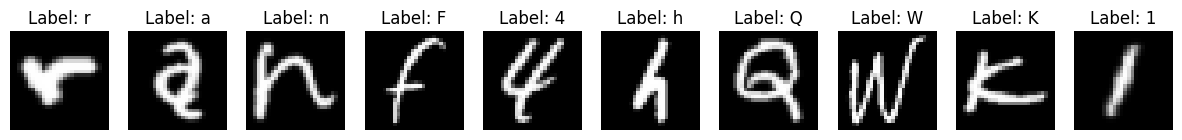

In [12]:
import numpy as np


def show_example_images(dataset, n=10):
    fig, axes = plt.subplots(1, n, figsize=(15, 3))
    for i in range(n):
        img, label = dataset[i]
        img = img.squeeze(0).numpy()  # 1x28x28 → 28x28
        axes[i].imshow(np.rot90(np.fliplr(img), k=1), cmap="gray")  # Xoay đúng hướng
        axes[i].set_title(f"Label: {class_labels[label]}")
        axes[i].axis("off")
    plt.show()


show_example_images(train_set)

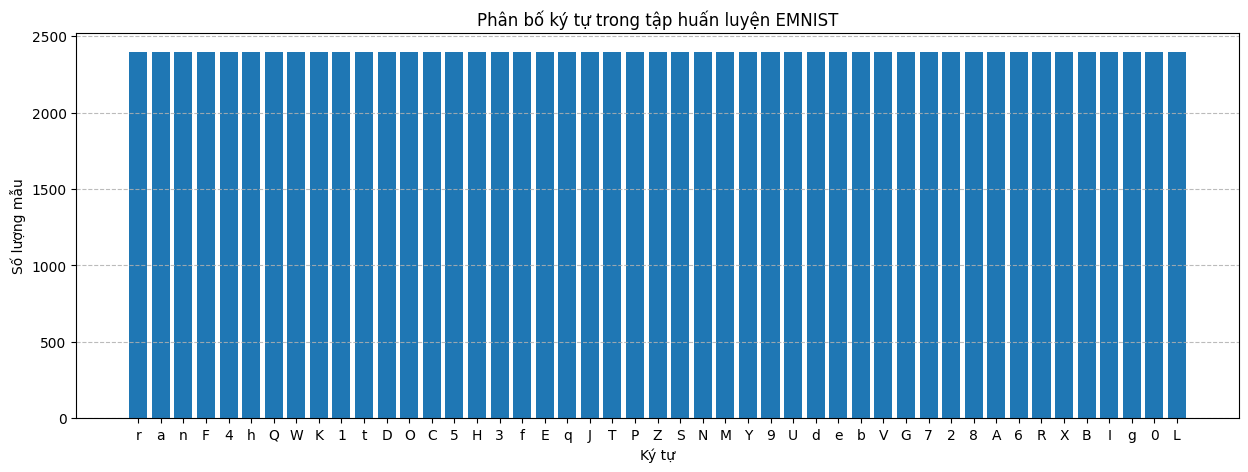

In [13]:
import pandas as pd
from collections import Counter

labels = [label for _, label in train_set]
label_counts = Counter(labels)

# Tạo DataFrame để dễ vẽ biểu đồ
df = pd.DataFrame({
    "label": [class_labels[i] for i in label_counts.keys()],
    "count": list(label_counts.values())
}).sort_values(by="count", ascending=False)

# Vẽ biểu đồ
plt.figure(figsize=(15, 5))
plt.bar(df["label"], df["count"])
plt.title("Phân bố ký tự trong tập huấn luyện EMNIST")
plt.xlabel("Ký tự")
plt.ylabel("Số lượng mẫu")
plt.grid(axis="y", linestyle="--", alpha=0.85)
plt.show()

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class EMNIST_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)  # (28-3+1)=26
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)  # (26-3+1)=24
        self.pool = nn.MaxPool2d(2, 2)  # 24 → 12
        self.fc1 = nn.Linear(64 * 5 * 5, 256)
        self.fc2 = nn.Linear(256, 47)  # 47 classes for EMNIST balanced

    # Hàm forward đã sửa lỗi
    def forward(self, x):
        # Input x có shape: (B, 1, 28, 28)

        # --- Block 1: CONV -> RELU -> POOL ---
        x = self.pool(F.relu(self.conv1(x)))
        # Sau conv1 -> (B, 32, 26, 26)
        # Sau pool -> (B, 32, 13, 13)

        # --- Block 2: CONV -> RELU -> POOL ---
        x = self.pool(F.relu(self.conv2(x)))
        # Sau conv2 -> (B, 64, 11, 11)
        # Sau pool -> (B, 64, 5, 5) -> Làm tròn xuống từ 5.5

        # --- Flatten và Fully Connected ---
        # Bây giờ kích thước đã đúng
        x = x.view(-1, 64 * 5 * 5)  # Kích thước khớp: (64*5*5 = 1600)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

In [26]:
from torch.utils.data import DataLoader
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = EMNIST_CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Tải lại DataLoader nếu chưa có
train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
test_loader = DataLoader(test_set, batch_size=64, shuffle=False)

In [27]:
def train(model, loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for imgs, labels in loader:
        imgs, labels = imgs.to(device), labels.to(device)

        # EMNIST ảnh bị xoay → xoay lại đúng chiều
        imgs = torch.rot90(torch.fliplr(imgs), k=1, dims=[2, 3])

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    acc = 100. * correct / total
    return running_loss / len(loader), acc


In [28]:
def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)
            imgs = torch.rot90(torch.fliplr(imgs), k=1, dims=[2, 3])
            outputs = model(imgs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    acc = 100. * correct / total
    return running_loss / len(loader), acc


In [29]:
num_epochs = 10
for epoch in range(num_epochs):
    train_loss, train_acc = train(model, train_loader, optimizer, criterion, device)
    val_loss, val_acc = evaluate(model, test_loader, criterion, device)

    print(f"Epoch {epoch + 1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"Val   Loss: {val_loss:.4f} | Val   Acc: {val_acc:.2f}%")

Epoch 1/10
Train Loss: 0.6947 | Train Acc: 78.07%
Val   Loss: 0.4702 | Val   Acc: 84.12%
Epoch 2/10
Train Loss: 0.3945 | Train Acc: 86.13%
Val   Loss: 0.3997 | Val   Acc: 86.44%
Epoch 3/10
Train Loss: 0.3383 | Train Acc: 87.80%
Val   Loss: 0.3862 | Val   Acc: 86.43%
Epoch 4/10
Train Loss: 0.3035 | Train Acc: 88.74%
Val   Loss: 0.3604 | Val   Acc: 87.21%
Epoch 5/10
Train Loss: 0.2731 | Train Acc: 89.60%
Val   Loss: 0.3648 | Val   Acc: 87.24%
Epoch 6/10
Train Loss: 0.2468 | Train Acc: 90.44%
Val   Loss: 0.3724 | Val   Acc: 87.19%
Epoch 7/10
Train Loss: 0.2261 | Train Acc: 91.09%
Val   Loss: 0.3821 | Val   Acc: 87.79%
Epoch 8/10
Train Loss: 0.2064 | Train Acc: 91.66%
Val   Loss: 0.4076 | Val   Acc: 87.06%
Epoch 9/10
Train Loss: 0.1901 | Train Acc: 92.21%
Val   Loss: 0.4152 | Val   Acc: 87.51%
Epoch 10/10
Train Loss: 0.1741 | Train Acc: 92.81%
Val   Loss: 0.4431 | Val   Acc: 86.94%


In [31]:
torch.save(model.state_dict(), "emnist_cnn.pth")

In [1]:
from tqdm import tqdm

y_true = []
y_pred = []

model.eval()
with torch.no_grad():
    for imgs, labels in tqdm(test_loader):
        imgs, labels = imgs.to(device), labels.to(device)
        imgs = torch.rot90(torch.fliplr(imgs), k=1, dims=[2, 3])
        outputs = model(imgs)
        _, predicted = outputs.max(1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

NameError: name 'model' is not defined

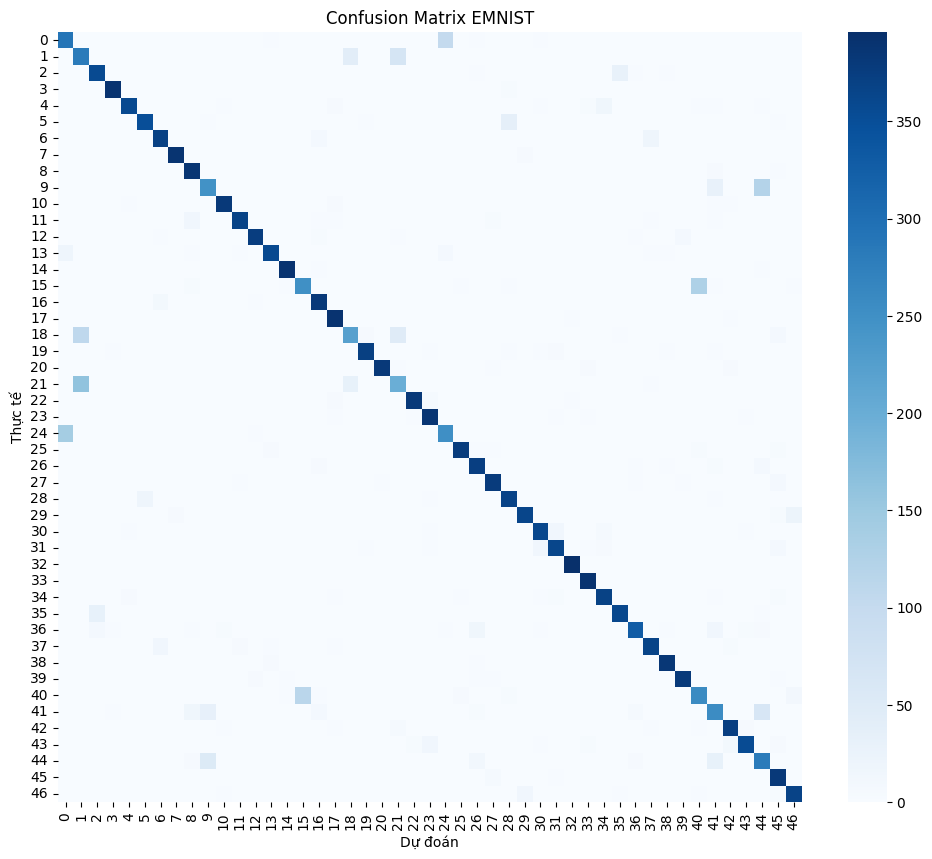

In [33]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=False, cmap="Blues")
plt.title("Confusion Matrix EMNIST")
plt.xlabel("Dự đoán")
plt.ylabel("Thực tế")
plt.show()

In [34]:
import pandas as pd

df_result = pd.DataFrame({
    "y_true": [class_labels[i] for i in y_true],
    "y_pred": [class_labels[i] for i in y_pred]
})

# Các dự đoán sai
df_wrong = df_result[df_result["y_true"] != df_result["y_pred"]]

# Đếm các cặp bị nhầm nhiều nhất
top_confusions = df_wrong.groupby(["y_true", "y_pred"]).size().reset_index(name="count")
top_confusions = top_confusions.sort_values("count", ascending=False)
print("Top 10 nhầm lẫn phổ biến:")
print(top_confusions.head(10))

Top 10 nhầm lẫn phổ biến:
    y_true y_pred  count
190      L      1    161
214      O      0    140
134      F      f    129
76       9      q    121
377      f      F    113
154      I      1    107
3        0      O    101
9        1      L     69
399      g      q     64
428      q      9     54


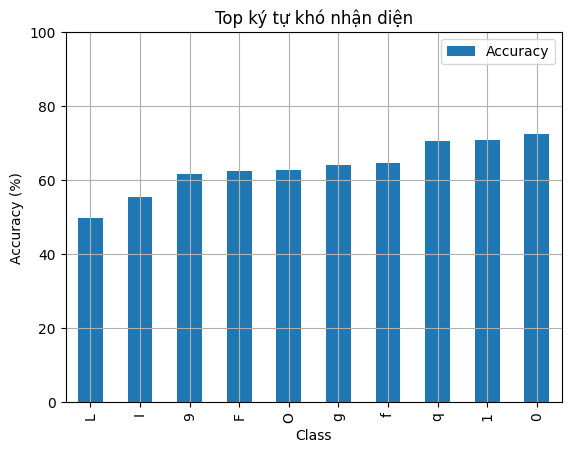

In [35]:
import numpy as np

class_correct = np.zeros(len(class_labels))
class_total = np.zeros(len(class_labels))

for t, p in zip(y_true, y_pred):
    class_total[t] += 1
    if t == p:
        class_correct[t] += 1

acc_per_class = 100. * class_correct / class_total
df_acc = pd.DataFrame({
    "Class": class_labels,
    "Accuracy": acc_per_class
}).sort_values("Accuracy", ascending=True)

# Vẽ 10 lớp có accuracy thấp nhất
df_acc.head(10).plot(x="Class", y="Accuracy", kind="bar", title="Top ký tự khó nhận diện")
plt.ylim(0, 100)
plt.ylabel("Accuracy (%)")
plt.grid(True)
plt.show()

In [36]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred, target_names=class_labels))

              precision    recall  f1-score   support

           0       0.63      0.72      0.68       400
           1       0.51      0.71      0.59       400
           2       0.88      0.89      0.88       400
           3       0.97      0.97      0.97       400
           4       0.96      0.90      0.93       400
           5       0.93      0.88      0.90       400
           6       0.92      0.93      0.92       400
           7       0.97      0.97      0.97       400
           8       0.88      0.97      0.92       400
           9       0.72      0.62      0.67       400
           A       0.96      0.95      0.95       400
           B       0.96      0.92      0.94       400
           C       0.96      0.94      0.95       400
           D       0.94      0.90      0.92       400
           E       0.97      0.97      0.97       400
           F       0.68      0.62      0.65       400
           G       0.90      0.95      0.93       400
           H       0.93    

Sử dụng device: cpu
Tải state_dict thành công!


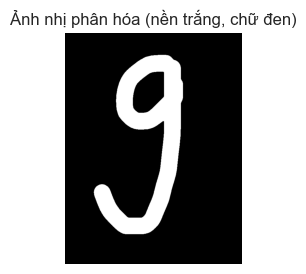

Ảnh: 'test_images/img_21.png'
Ký tự dự đoán là: 'g'
Độ tự tin (Confidence): 99.93%


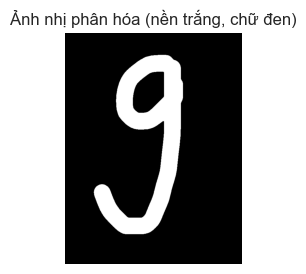

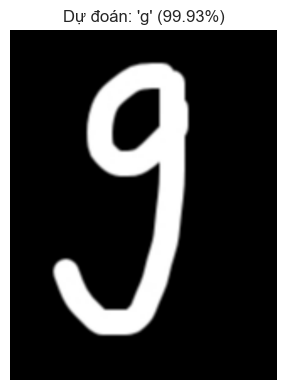

In [5]:
import torch
import torch.nn as nn
from PIL import Image, ImageFilter
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F


# --- 1. ĐỊNH NGHĨA LẠI KIẾN TRÚC MODEL (PHIÊN BẢN ĐÚNG) ---
# Sử dụng lại kiến trúc gốc của bạn với kích thước flatten là 64 * 12 * 12
class EMNIST_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)  # (28-3+1)=26
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)  # (26-3+1)=24
        self.pool = nn.MaxPool2d(2, 2)  # 24 → 12
        self.fc1 = nn.Linear(64 * 5 * 5, 256)
        self.fc2 = nn.Linear(256, 47)  # 47 classes for EMNIST balanced

    # Hàm forward đã sửa lỗi
    def forward(self, x):
        # Input x có shape: (B, 1, 28, 28)

        # --- Block 1: CONV -> RELU -> POOL ---
        x = self.pool(F.relu(self.conv1(x)))
        # Sau conv1 -> (B, 32, 26, 26)
        # Sau pool -> (B, 32, 13, 13)

        # --- Block 2: CONV -> RELU -> POOL ---
        x = self.pool(F.relu(self.conv2(x)))
        # Sau conv2 -> (B, 64, 11, 11)
        # Sau pool -> (B, 64, 5, 5) -> Làm tròn xuống từ 5.5

        # --- Flatten và Fully Connected ---
        # Bây giờ kích thước đã đúng
        x = x.view(-1, 64 * 5 * 5)  # Kích thước khớp: (64*5*5 = 1600)
        x = F.relu(self.fc1(x))
        return self.fc2(x)


# --- 2. LOAD MODEL VÀ CẤU HÌNH ---
# Ánh xạ từ index sang ký tự
# Chú ý: EMNIST 'byclass' có 62 lớp, 'balanced' có 47 lớp. 
# Dựa trên fc2(..., 47), model của bạn dùng bộ 'balanced'.
class_labels = "0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabdefghnqrt"  # 47 lớp của EMNIST Balanced

# Thiết lập device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Sử dụng device: {device}")

# Khởi tạo model và load trọng số đã lưu
model = EMNIST_CNN().to(device)
try:
    # Dòng này bây giờ sẽ chạy thành công
    model.load_state_dict(torch.load("emnist_cnn.pth", map_location=device))
    print("Tải state_dict thành công!")
except FileNotFoundError:
    print("Lỗi: Không tìm thấy file 'emnist_cnn.pth'. Hãy chắc chắn file model nằm đúng thư mục.")
    exit()
except RuntimeError as e:
    print(f"Lỗi Runtime khi tải model: {e}")
    print("Vui lòng kiểm tra lại kiến trúc model có khớp 100% với file đã lưu không.")
    exit()

# BẮT BUỘC: Chuyển model sang chế độ đánh giá
model.eval()


# --- 3. HÀM DỰ ĐOÁN (Giữ nguyên, không cần sửa) ---
def predict_emnist(image_path: str, model_to_use: nn.Module):
    try:
        img = Image.open(image_path)
    except FileNotFoundError:
        return f"Lỗi: Không tìm thấy ảnh tại đường dẫn '{image_path}'", 0.0

    # Chuyển ảnh về grayscale nếu không phải ảnh đen trắng
    if img.mode != "L":
        img = img.convert("L")

    # Áp dụng threshold để ảnh chỉ còn 2 mức: 0 hoặc 255
    # Ngưỡng 128 có thể điều chỉnh (nhưng thường ổn)
    img_np = np.array(img)
    threshold = 128
    binary_np = np.where(img_np > threshold, 0, 255).astype(np.uint8)  # thành mảng 0 và 255

    # Kiểm tra mean để biết nền sáng hay tối
    mean_pixel = np.mean(binary_np)

    # Nếu nền tối (mean < 127) → đảo màu
    if mean_pixel > 127:
        binary_np = 255 - binary_np  # đảo màu: 0 ↔ 255

    # Chuyển lại thành PIL image
    img = Image.fromarray(binary_np)

    transform_pipeline = transforms.Compose([
        transforms.Resize((28, 28)),
        transforms.ToTensor(),
    ])

    img_tensor = transform_pipeline(img)

    img_tensor = torch.rot90(torch.fliplr(img_tensor), k=0, dims=[1, 2])
    img_tensor = img_tensor.unsqueeze(0).to(device)

    # print(img_tensor)
    with torch.no_grad():
        output = model_to_use(img_tensor)
        probabilities = torch.softmax(output, dim=1)
        confidence, pred_class_index = torch.max(probabilities, 1)
        pred_index = pred_class_index.item()

        # Kiểm tra index nằm trong class_labels
        if pred_index < len(class_labels):
            pred_label = class_labels[pred_index]
        else:
            pred_label = f"Index out of range: {pred_index}"

        confidence_score = confidence.item()

    plt.figure(figsize=(3, 3))
    plt.imshow(img, cmap='gray')
    plt.title(f"Ảnh nhị phân hóa (nền trắng, chữ đen)")
    plt.axis("off")
    plt.show()

    return pred_label, confidence_score


# --- 4. THỰC THI DỰ ĐOÁN ---
image_file = "test_images/img_21.png"  # Thay bằng đường dẫn ảnh của bạn
predicted_char, confidence = predict_emnist(image_file, model)

if "Lỗi" not in str(predicted_char):
    print(f"Ảnh: '{image_file}'")
    print(f"Ký tự dự đoán là: '{predicted_char}'")
    print(f"Độ tự tin (Confidence): {confidence:.2%}")
else:
    print(predicted_char)


def show_prediction_image(image_path: str, model_to_use: nn.Module):
    # Gọi lại hàm dự đoán
    pred_label, confidence_score = predict_emnist(image_path, model_to_use)

    # Mở ảnh gốc để hiển thị (ảnh màu hoặc grayscale đều được)
    img = Image.open(image_path)

    plt.figure(figsize=(4, 4))
    plt.imshow(img, cmap='gray')  # cmap='gray' vẫn hiển thị tốt ảnh màu
    plt.title(f"Dự đoán: '{pred_label}' ({confidence_score * 100:.2f}%)", fontsize=12)
    plt.axis("off")
    plt.tight_layout()
    plt.show()


show_prediction_image(image_file, model)
